# Library

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from analysis import *
from utils import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, confusion_matrix

# Data

In [91]:
df = pd.read_csv(
    r'../../data/cleaned/clean3.csv',
    encoding='utf-8',
)

In [92]:
df.head()

,price,availability,number_of_products_sold,revenue_generated,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,lead_time,...,product_type,sku,customer_demographics,shipping_carriers,location,inspection_results,transportation_modes,routes,shipping_times_category,supplier_name
0,69.808006,55,802,8661.996792,58,7,96,4,2.956572,29,...,haircare,SKU0,Non-binary,Carrier B,Mumbai,Pending,Road,Route B,Standard,Supplier 3
1,14.843523,95,736,7460.900065,53,30,37,2,9.716575,23,...,skincare,SKU1,Female,Carrier A,Mumbai,Pending,Road,Route B,Express,Supplier 3
2,11.319683,34,8,9577.749626,1,10,88,2,8.054479,12,...,haircare,SKU2,Unknown,Carrier B,Mumbai,Pending,Air,Route C,Express,Supplier 1
3,61.163343,68,83,7766.836426,23,13,59,6,1.729569,24,...,skincare,SKU3,Non-binary,Carrier C,Kolkata,Fail,Rail,Route A,Standard,Supplier 5
4,4.805496,26,871,2686.505152,5,3,56,8,3.890548,5,...,skincare,SKU4,Non-binary,Carrier A,Delhi,Fail,Air,Route A,Economy,Supplier 1


# Load metadata

In [93]:
df = load_metadata(
    df,
    r"../../data/metadata/metadata3.json",
)

# Overview

## Check

In [94]:
print(f"Num of varibles:", df.shape[1])
print(f"Num of rows:", df.shape[0])

Num of varibles: 25
Num of rows: 100


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   price                    100 non-null    float64 
 1   availability             100 non-null    int64   
 2   number_of_products_sold  100 non-null    int64   
 3   revenue_generated        100 non-null    float64 
 4   stock_levels             100 non-null    int64   
 5   lead_times               100 non-null    int64   
 6   order_quantities         100 non-null    int64   
 7   shipping_times           100 non-null    int64   
 8   shipping_costs           100 non-null    float64 
 9   lead_time                100 non-null    int64   
 10  production_volumes       100 non-null    int64   
 11  manufacturing_lead_time  100 non-null    int64   
 12  manufacturing_costs      100 non-null    float64 
 13  defect_rates             100 non-null    float64 
 14  costs      

In [96]:
df.isnull().sum()

price                      0
availability               0
number_of_products_sold    0
revenue_generated          0
stock_levels               0
lead_times                 0
order_quantities           0
shipping_times             0
shipping_costs             0
lead_time                  0
production_volumes         0
manufacturing_lead_time    0
manufacturing_costs        0
defect_rates               0
costs                      0
product_type               0
sku                        0
customer_demographics      0
shipping_carriers          0
location                   0
inspection_results         0
transportation_modes       0
routes                     0
shipping_times_category    0
supplier_name              0
dtype: int64

## Varibles and target

In [97]:
target = ['supplier_name']
variablies = [col for col in df.columns if col not in target]

print(target)
print(variablies)

['supplier_name']
['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs', 'product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category']


# Grouping Varibles by their respective data types

In [98]:
numerical_cols, categorical_cols, _ = group_columns_by_type(df, display_info=True)

Total numeric columns: 15
Numeric columns: ['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs']

Total categorical columns: 10
Categorical columns: ['product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category', 'supplier_name']



# Multivariate

In [99]:
df_numerical = df[numerical_cols].copy()
df_categorical = df[categorical_cols].copy()

In [128]:
encoder = OrdinalEncoder(
    categories=[["Supplier 1", "Supplier 2", "Supplier 3", "Supplier 4", "Supplier 5"]]
)
df["supplier_name"] = encoder.fit_transform(df[["supplier_name"]])
df["supplier_name"].unique()

array([2., 0., 4., 3., 1.])

## Visualization and dimensionality reduction

### PCA

In [100]:
# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numerical)

#### Selection `n_components`

In [101]:
n_components_pca_full = min(df_numerical.shape[0], df_numerical.shape[1])

In [102]:
pca_full = PCA(n_components=n_components_pca_full, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

In [103]:
explained_var = pca_full.explained_variance_ratio_
eigenvalues = pca_full.explained_variance_
cum_var = np.cumsum(explained_var)

summary_df = pd.DataFrame(
        {
            "eigenvalue": eigenvalues,
            "variance_%": explained_var * 100,
            "variance_(cumulative)_%": cum_var * 100,
        }
    )

summary_df.index = [f"PC{i+1}" for i in range(len(explained_var))]
summary_df.round(2)

,eigenvalue,variance_%,variance_(cumulative)_%
PC1,1.68,11.07,11.07
PC2,1.49,9.85,20.92
PC3,1.48,9.75,30.67
PC4,1.38,9.11,39.78
PC5,1.21,8.00,47.77
PC6,1.20,7.89,55.67
PC7,1.04,6.88,62.55
PC8,0.99,6.56,69.11
PC9,0.94,6.21,75.32
PC10,0.83,5.47,80.79


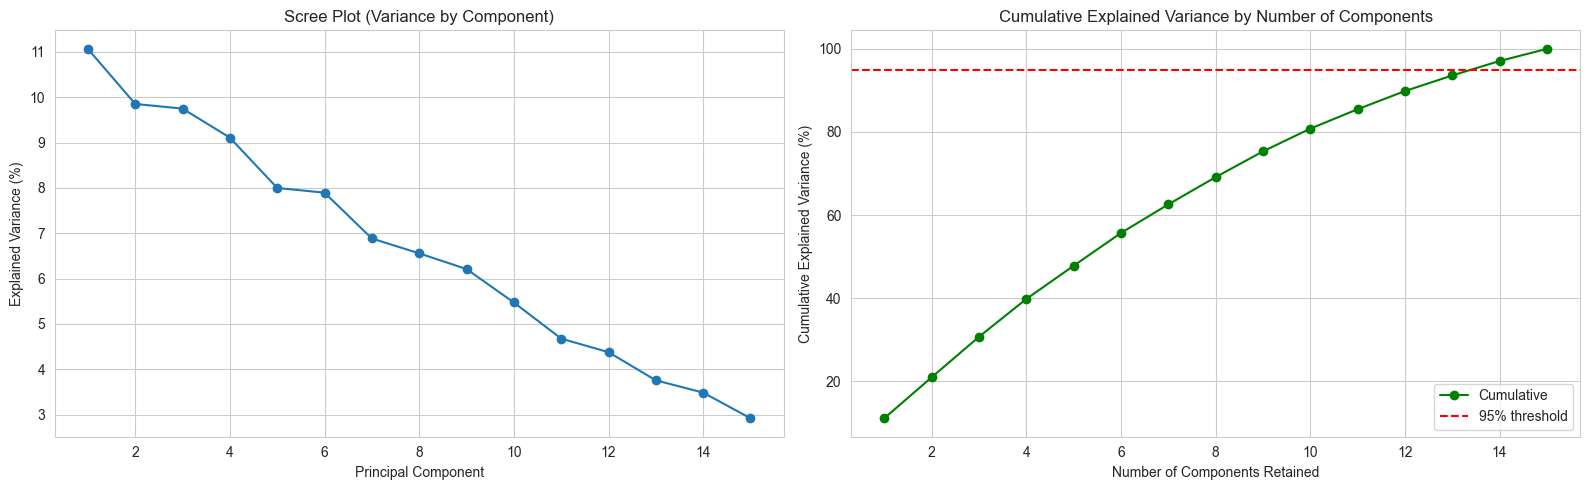

In [104]:
plot_pca_contributions(pca_full, 0.95)

#### Main

In [105]:
pca = PCA(n_components=13, random_state=42)
X_pca = pca.fit(X_scaled)

In [106]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings

array([[-5.44959167e-01, -3.91226341e-01, -2.04777675e-01,
        -2.32361210e-01, -1.72039626e-01,  2.75405594e-01,
        -3.94632748e-02,  1.12273814e-01, -3.74049423e-01,
         1.60277186e-01, -1.49660764e-01, -7.85893170e-02,
        -1.37794648e-01],
       [-3.38233190e-02,  5.82607365e-01,  1.80394110e-01,
        -1.90287235e-01, -2.71351130e-01,  2.34258747e-01,
         5.33776195e-02,  8.59324785e-03, -4.88988025e-01,
        -2.38647496e-01, -3.03334747e-01, -8.92178837e-03,
         1.54339852e-01],
       [ 1.25170694e-01, -9.89961263e-02,  2.31011375e-01,
        -1.35689702e-01, -4.21952455e-01,  6.03630577e-01,
         6.29523232e-02, -1.57358335e-01,  2.80609349e-01,
        -3.00163653e-01,  3.78228474e-01, -5.41594516e-02,
         5.35261684e-02],
       [-1.44724813e-01, -1.12643125e-01, -3.47492650e-01,
         6.03200852e-01, -2.66417977e-01,  6.16108851e-02,
        -5.10201144e-02, -3.12325028e-01,  3.72820224e-02,
        -1.98076315e-01, -2.08742898e

In [107]:
get_pca_contribution_table(
    pca,
    variable_names=numerical_cols,
    percent=True
)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
price,17.71 %,10.25 %,2.84 %,3.91 %,2.44 %,6.34 %,0.15 %,1.27 %,14.87 %,3.1 %,3.16 %,0.93 %,3.34 %
availability,0.07 %,22.74 %,2.2 %,2.62 %,6.08 %,4.59 %,0.27 %,0.01 %,25.41 %,6.87 %,12.99 %,0.01 %,4.19 %
number_of_products_sold,0.93 %,0.66 %,3.61 %,1.33 %,14.69 %,30.46 %,0.38 %,2.49 %,8.37 %,10.87 %,20.19 %,0.44 %,0.5 %
revenue_generated,1.25 %,0.85 %,8.17 %,26.37 %,5.86 %,0.32 %,0.25 %,9.82 %,0.15 %,4.73 %,6.15 %,31.13 %,2.53 %
stock_levels,0.34 %,4.18 %,3.25 %,12.66 %,9.19 %,12.49 %,21.72 %,2.67 %,0.65 %,1.8 %,0.01 %,8.88 %,21.32 %
lead_times,7.12 %,13.21 %,3.72 %,8.73 %,3.01 %,3.74 %,0.91 %,8.32 %,3.44 %,15.78 %,1.11 %,3.38 %,14.75 %
order_quantities,3.79 %,15.0 %,5.12 %,0.01 %,0.03 %,13.46 %,4.3 %,0.76 %,0.16 %,35.13 %,10.55 %,4.93 %,0.1 %
shipping_times,0.24 %,1.17 %,2.61 %,0.03 %,11.17 %,22.74 %,2.31 %,30.74 %,8.3 %,0.05 %,9.23 %,5.56 %,4.21 %
shipping_costs,0.03 %,3.25 %,0.0 %,4.5 %,17.44 %,3.29 %,35.17 %,12.35 %,0.17 %,7.73 %,3.19 %,0.31 %,7.54 %
lead_time,6.36 %,11.1 %,16.66 %,13.22 %,0.77 %,0.16 %,3.36 %,0.17 %,0.31 %,0.14 %,0.32 %,11.79 %,4.13 %


### MCA

In [108]:
df_categorical.columns

Index(['product_type', 'sku', 'customer_demographics', 'shipping_carriers',
       'location', 'inspection_results', 'transportation_modes', 'routes',
       'shipping_times_category', 'supplier_name'],
      dtype='object')

#### Select `n_components`

In [109]:
n_components_mca_full = min(df_categorical.shape[0], df_categorical.shape[1])

mca_full = MCA(
    n_components=n_components_mca_full, 
    n_iter=10,
    copy=True,
    check_input=True,
    engine="sklearn",
    random_state=42,
    one_hot=True
).fit(df_categorical)

In [110]:
mca_full.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.292,2.37%,2.37%
1,0.284,2.31%,4.68%
2,0.274,2.23%,6.91%
3,0.256,2.08%,9.00%
4,0.249,2.02%,11.02%
5,0.236,1.92%,12.94%
6,0.232,1.89%,14.83%
7,0.220,1.79%,16.62%
8,0.213,1.73%,18.35%


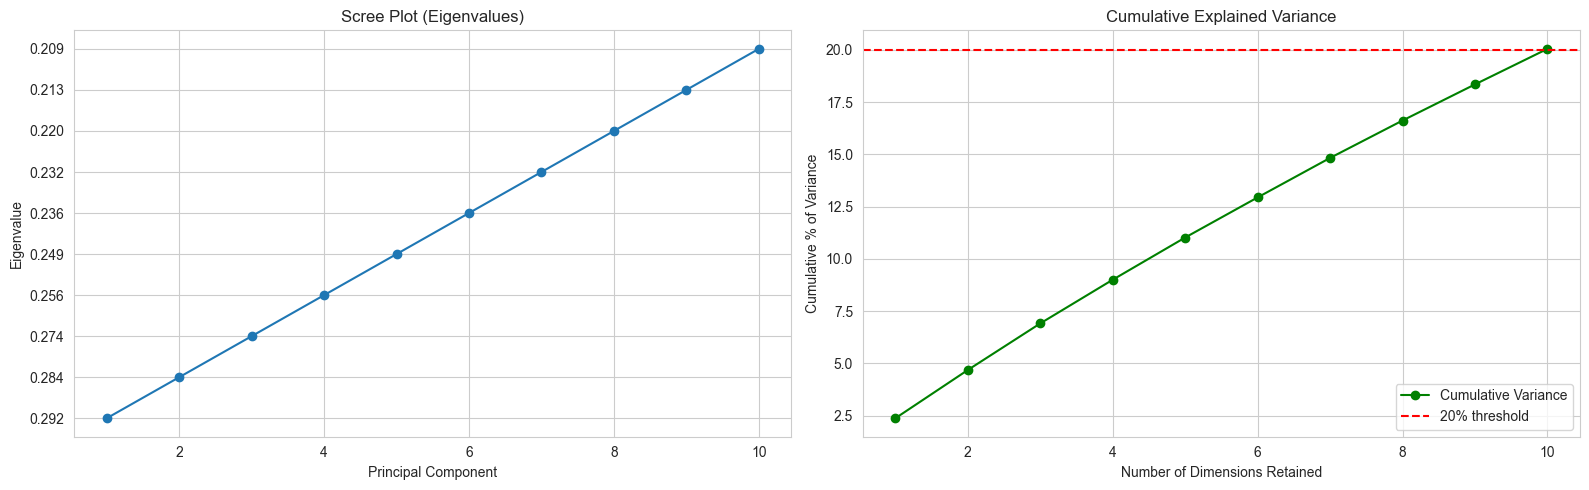

In [111]:
plot_mca_contributions(mca_full, 0.20)

#### Main

In [112]:
mca = MCA(
        n_components=2,
        n_iter=10,
        copy=True,
        check_input=True,
        engine="sklearn",
        random_state=42,
        one_hot=True,
    )
mca = mca.fit(df_categorical)

In [113]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.292,2.37%,2.37%
1,0.284,2.31%,4.68%


In [114]:
mca.plot(
    df_categorical,
    x_component=0, y_component=1,
    show_column_markers=True,
    show_row_markers=False,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

In [115]:
mca.column_contributions_.head()

,0,1
product_type__cosmetics,0.000296,0.066492
product_type__haircare,0.031001,0.044678
product_type__skincare,0.031043,0.000169
sku__SKU0,0.001031,0.013327
sku__SKU1,0.000341,0.004400


In [116]:
get_mca_contribution_table(mca, percent=True)

,Dim1,Dim2
product_type,6.23 %,11.13 %
sku,34.25 %,35.22 %
customer_demographics,8.0 %,9.19 %
shipping_carriers,4.6 %,10.37 %
location,1.99 %,8.7 %
inspection_results,9.0 %,7.4 %
transportation_modes,8.49 %,7.05 %
routes,5.53 %,1.0 %
shipping_times_category,1.83 %,4.59 %
supplier_name,20.09 %,5.35 %


## Classification & segregation of labeled groups

In [130]:
# Normalization numerical cols
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numerical)

### LDA (Linear Discriminant Analysis)

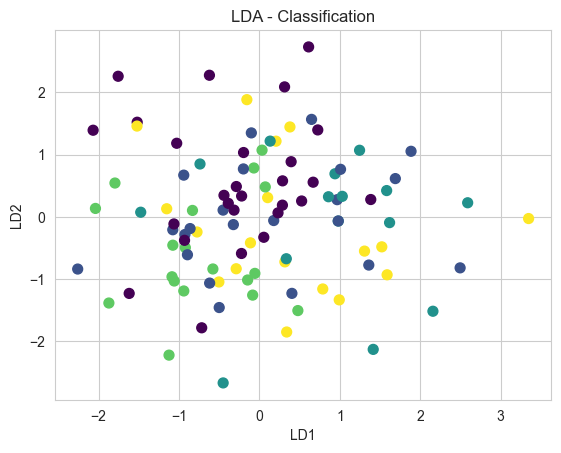

In [146]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, df['supplier_name'])

plt.scatter(X_lda[:, 0], X_lda[:, 1], c=df['supplier_name'], cmap='viridis', s=50)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA - Classification')
plt.show()

In [147]:
lda_pred = lda.predict(X_scaled)

In [152]:
print("Confusion Matrix:\n")
print(confusion_matrix(df['supplier_name'], lda_pred))

Confusion Matrix:

[[16  6  0  4  1]
 [ 4  7  3  5  3]
 [ 4  2  6  1  2]
 [ 5  2  0 10  1]
 [ 5  2  3  2  6]]


In [153]:
print("Classification Report:\n")
print(classification_report(df['supplier_name'], lda_pred))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.47      0.59      0.52        27
         1.0       0.37      0.32      0.34        22
         2.0       0.50      0.40      0.44        15
         3.0       0.45      0.56      0.50        18
         4.0       0.46      0.33      0.39        18

    accuracy                           0.45       100
   macro avg       0.45      0.44      0.44       100
weighted avg       0.45      0.45      0.44       100



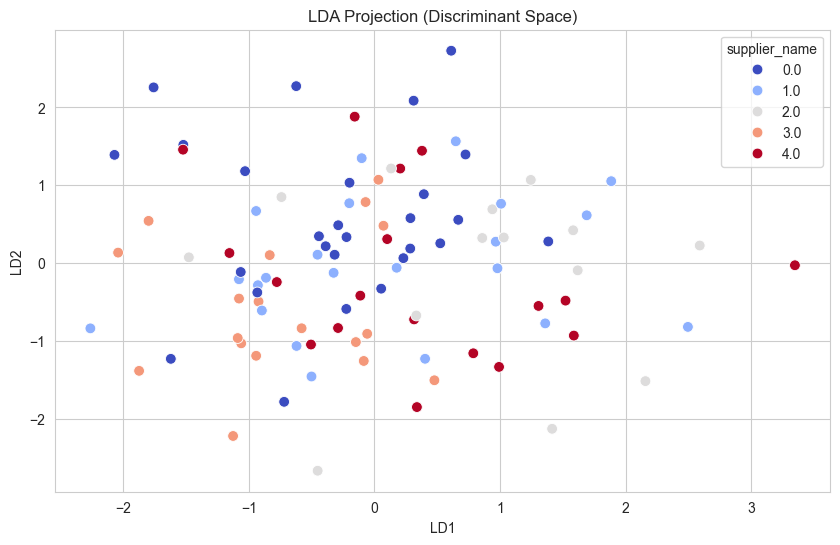

In [154]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_lda[:, 0],
    y=X_lda[:, 1] if X_lda.shape[1] > 1 else [0] * len(X_lda),
    hue=df['supplier_name'],
    palette="coolwarm",
    s=60,
)
plt.title("LDA Projection (Discriminant Space)")
plt.xlabel("LD1")
if X_lda.shape[1] > 1:
    plt.ylabel("LD2")
plt.grid(True)
plt.show()

In [158]:
lda_weights = pd.Series(lda.coef_[0], index=df_numerical.columns)
top_features = lda_weights.abs().sort_values(ascending=False).head(10)

print("Top 10 important features for class separation:")
print(top_features)

Top 10 important features for class separation:
defect_rates               0.294393
price                      0.266625
stock_levels               0.236992
lead_time                  0.233828
number_of_products_sold    0.196746
manufacturing_lead_time    0.167619
order_quantities           0.140293
costs                      0.132296
availability               0.102079
revenue_generated          0.087389
dtype: float64


## Uncovering hidden structures & latent groupings

#### Separate variables into feasible combinations.

In [ ]:
# Weather conditions
weather_cols = [
    "temperature",
    "humidity",
    "wind_speed",
    "precipitation_(%)",
    "atmospheric_pressure",
    "visibility_(km)",
    "cloud_cover",
    "uv_index"
]

# Location & Seasonality
seasonal_cols = ["season", "location"]

combinations = [weather_cols] + [seasonal_cols]
combinations_name = ["weather_cols", "seasonal_cols"]

In [ ]:
df_for_cluster = df[weather_cols+seasonal_cols].copy()

### Kmeans

Run KMeans clustering for: weather_cols
KMeans optimization:
- Optimal number of clusters: 2
- Silhouette Score: 0.300


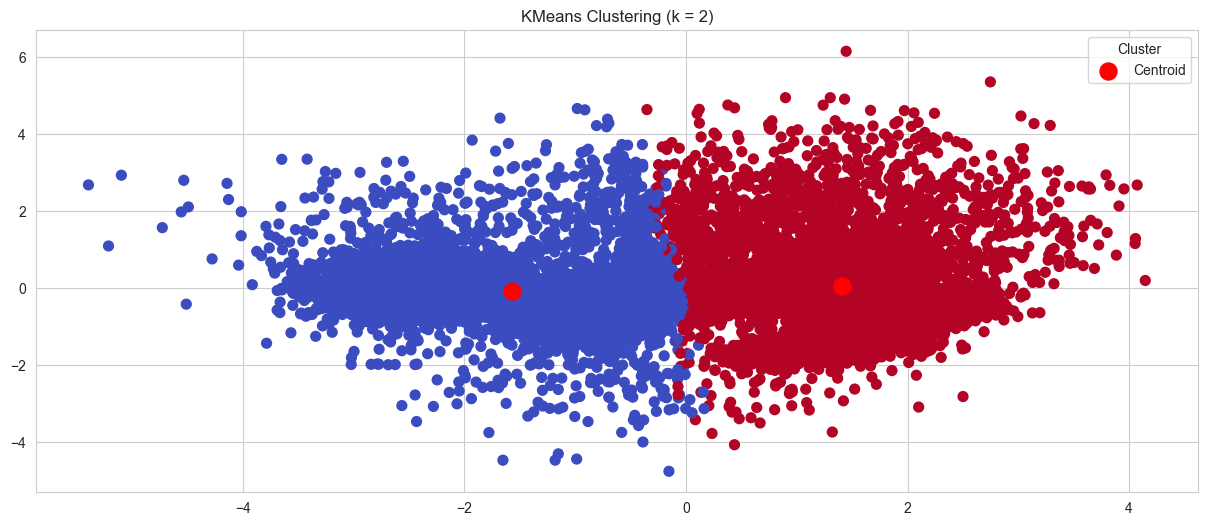


Run KMeans clustering for: seasonal_cols
KMeans optimization:
- Optimal number of clusters: 10
- Silhouette Score: 0.855


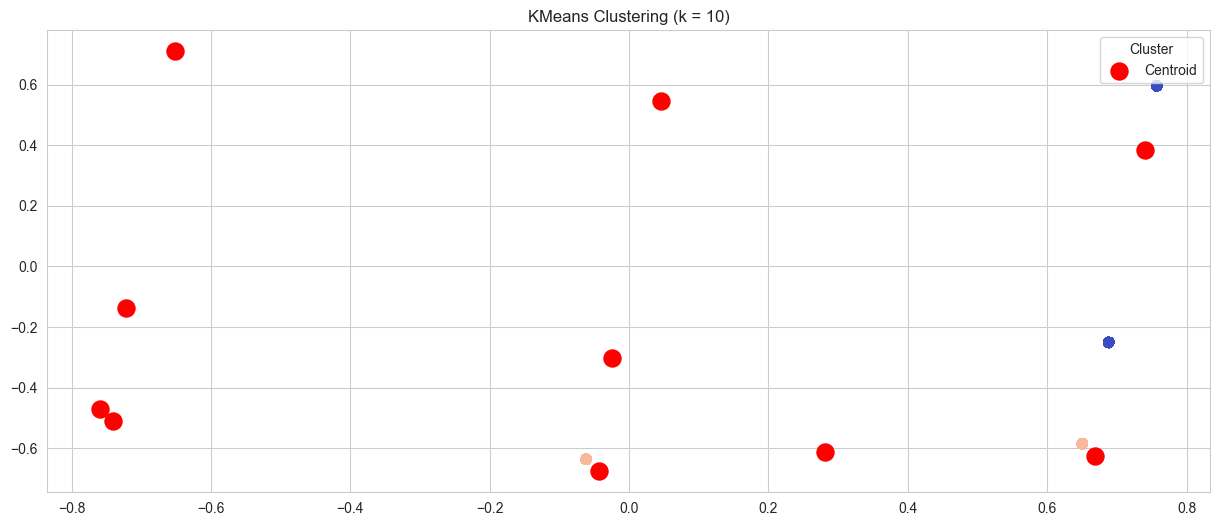

In [ ]:
for obj, name in zip(combinations, combinations_name):
    print(f"Run KMeans clustering for: {name}")
    df_for_cluster[f"cluster_{name}"] = run_kmeans_clustering(df[obj].copy(), cluster_range=range(2, 11))
    print()

### Analysis

In [ ]:
for obj, name in zip(combinations, combinations_name):
    print(f"Cluster counts for: {name}")
    print(df_for_cluster[obj + [f"cluster_{name}"]].value_counts(subset=[f"cluster_{name}"]))
    print("-"*50)

Cluster counts for: weather_cols
cluster_weather_cols
1                       6956
0                       6244
Name: count, dtype: int64
--------------------------------------------------
Cluster counts for: seasonal_cols
cluster_seasonal_cols
0                        3166
1                        2308
6                        1644
5                         930
3                         900
2                         888
8                         859
7                         851
4                         848
9                         806
Name: count, dtype: int64
--------------------------------------------------


<Axes: xlabel='uv_index', ylabel='Count'>

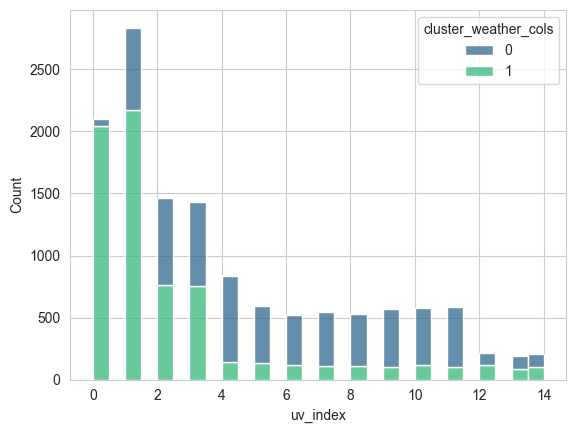

In [ ]:
sns.histplot(
    data=df_for_cluster[weather_cols + ["cluster_weather_cols"]],
    x="uv_index",
    hue="cluster_weather_cols",
    multiple="stack",
    palette="viridis",
)

## Investigating the association between two variables

### Separate variables into feasible combinations

In [ ]:
group_A = weather_cols
group_B = seasonal_cols

In [ ]:
df_A_B_for_cca = df[group_A+group_B]

### Main

In [ ]:
X_a = df[group_A]
X_b = df[group_B]

X_a, X_b = X_a.align(X_b, join='inner', axis=0)

In [ ]:
def preprocessing_for_cca(df: pd.DataFrame):
    num_cols, cate_cols, _ = group_columns_by_type(df, False)
    if num_cols:
        df[num_cols] = preprocessing_numerical(df[num_cols], numerical_cols=num_cols, is_return_scaler=False)
    if cate_cols:
        df = pd.concat([df, preprocessing_categorical(df[cate_cols], nominal_cols=cate_cols)], axis = 1)
        df.drop(columns=cate_cols, axis=1, inplace=True)
    return df

In [ ]:
X_a_scaled = preprocessing_for_cca(X_a)
X_b_scaled = preprocessing_for_cca(X_b)

In [ ]:
n_components_cca = min(X_a.shape[1], X_b.shape[1])
cca = CCA(n_components=n_components_cca)
X_a_c, X_b_c = cca.fit_transform(X_a_scaled, X_b_scaled)

In [ ]:
corrs = [np.corrcoef(X_a_c[:, i], X_b_c[:, i])[0, 1] for i in range(n_components_cca)]
print(f"Correlation canonical: {corrs}")

Correlation canonical: [np.float64(0.5128185176486103), np.float64(0.04104586082320685)]


In [ ]:
for i in range(n_components_cca):
    r = np.corrcoef(X_a_c[:, i], X_b_c[:, i])[0, 1]
    print(f"CC{i+1}: {r:.3f}")

CC1: 0.513
CC2: 0.041


In [ ]:
X_a_weights = pd.DataFrame(cca.x_weights_, index=X_a_scaled.columns, columns=['CC1', 'CC2'])
X_b_weights = pd.DataFrame(cca.y_weights_, index=X_b_scaled.columns, columns=['CC1', 'CC2'])

In [ ]:
def get_sorted_loadings_cca(weights: pd.DataFrame, cc: int=1):
    sorted_weights = weights[[f"CC{str(cc)}"]].copy()
    
    sorted_weights["abs_loading"] = sorted_weights[f"CC{str(cc)}"].abs()
    
    sorted_weights = sorted_weights.sort_values(by="abs_loading", ascending=False)
    
    return sorted_weights.drop(columns="abs_loading")

In [ ]:
get_sorted_loadings_cca(X_a_weights, cc=1).head()

,CC1
temperature,0.874316
cloud_cover_partly cloudy,0.239005
visibility_(km),0.221862
cloud_cover_overcast,0.189368
precipitation_(%),-0.179102


In [ ]:
get_sorted_loadings_cca(X_b_weights, cc=1).head()

,CC1
season_Winter,-0.888484
location_mountain,-0.334522
location_inland,-0.314152
season_Summer,0.000712
season_Spring,0.000142


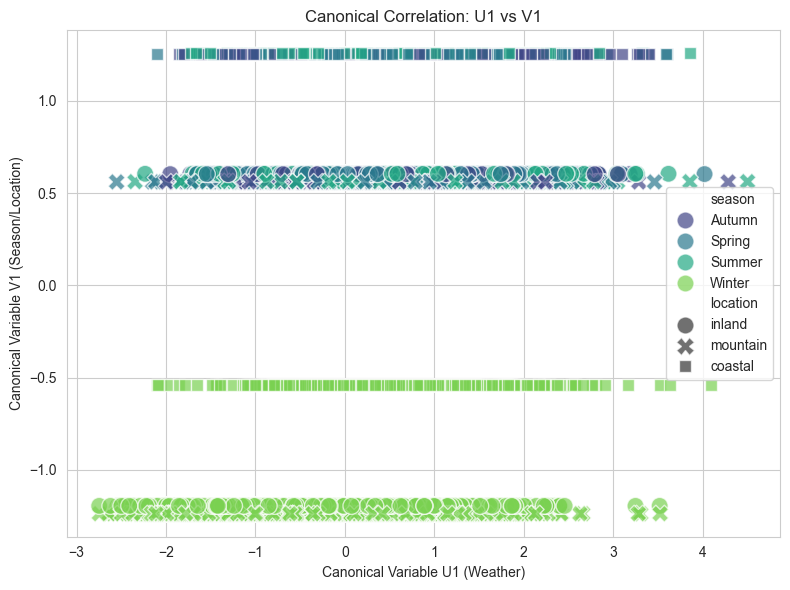

In [ ]:
cca_df = pd.DataFrame({
    "U1": X_a_c[:, 0],
    "V1": X_b_c[:, 0],
    "U2": X_a_c[:, 1],
    "V2": X_b_c[:, 1],
    "season": df["season"],
    "location": df["location"]
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=cca_df, x="U1", y="V1", hue="season", style="location", palette="viridis", alpha=0.7, s=150)
plt.title("Canonical Correlation: U1 vs V1")
plt.xlabel("Canonical Variable U1 (Weather)")
plt.ylabel("Canonical Variable V1 (Season/Location)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Outliers

In [ ]:
outlier_list = ["temperature", "wind_speed", "atmospheric_pressure", "visibility_(km)"]

In [ ]:
df = cap_outliers_by_iqr(df, 'temperature', lower=-20, upper=50)
df = cap_outliers_by_iqr(df, 'wind_speed')
df = cap_outliers_by_iqr(df, 'visibility_(km)')

In [ ]:
df = cap_outliers_by_iqr(df, 'atmospheric_pressure', lower=950, upper=1050)
df = remove_outliers_by_iqr(df, 'atmospheric_pressure')

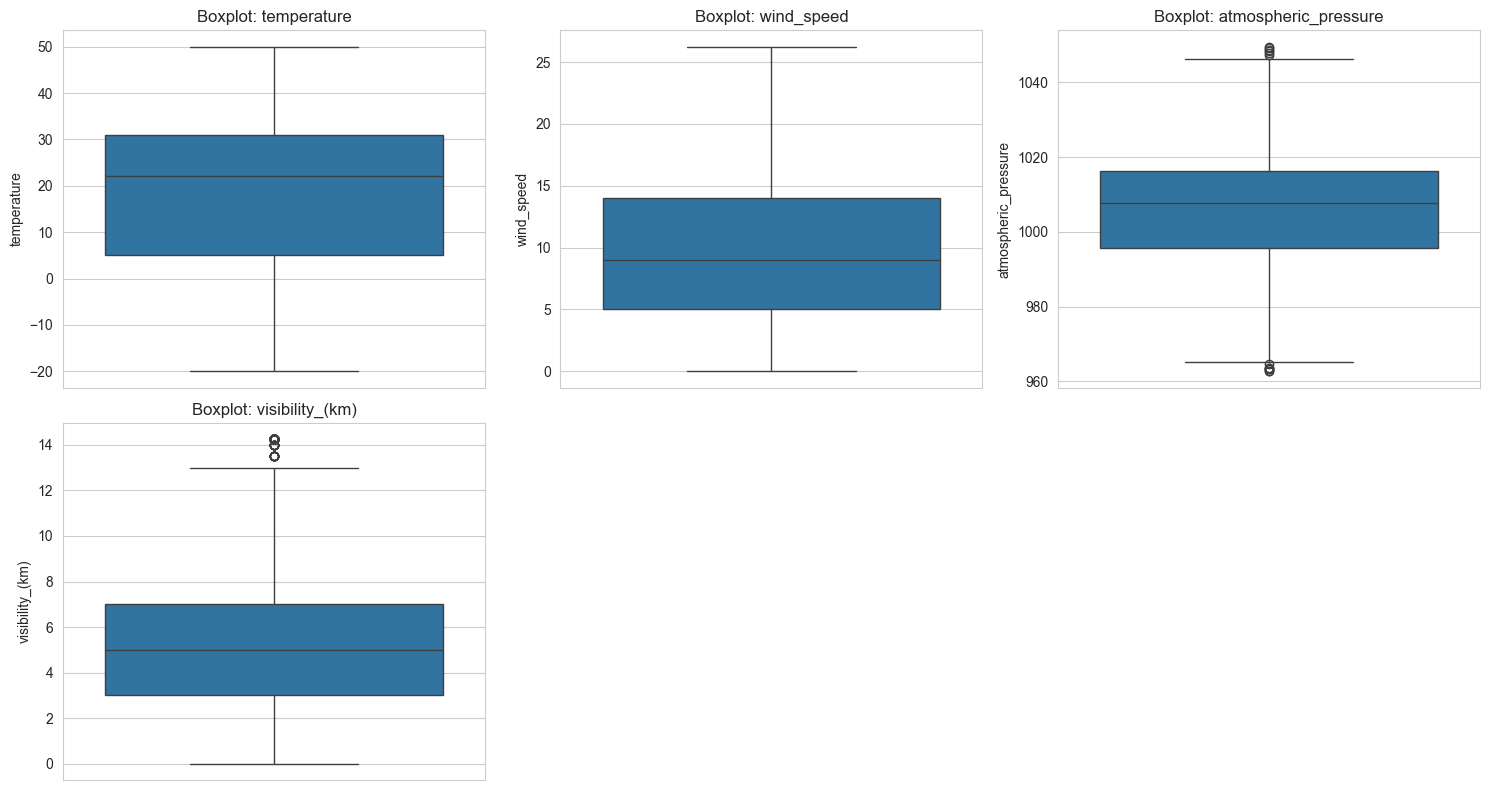

In [ ]:
plot_multiple_boxplots(df, outlier_list)

# Save

In [ ]:
df = pd.concat([df[numerical_cols + categorical_cols], df_target], axis=1)

## Metadata `.json`

In [ ]:
save_metadata(
    df,
    r"../../data/metadata/metadata4.json",
)

## To `.csv`

In [ ]:
df.to_csv(
    r"../../data/cleaned/clean4.csv",
    index=False,
    encoding="utf-8",
)